<a href="https://colab.research.google.com/github/ping-Mel/ERV-V2-Assignments/blob/main/session9/s9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class Models:
    """
    In this class, we organize our neural network architectures as nested/inner classes.
    This approach groups related functionalities and creates an organized and encapsulated
    code structure. Each neural network architecture is defined as an inner class within
    this Models class. This allows for easy instantiation and clear hierarchy of neural
    network models, each with its distinct architecture and characteristics.
    """
    @staticmethod
    def evaluate_model(model_class, input_size=(3, 32, 32)):
        """
        Static method to evaluate the model architecture.
        This method will print a summary of the model showing the layers and parameters.

        Parameters:
        model_class (class): The inner class representing the neural network architecture to evaluate.
        input_size (tuple): The size of the input to the model. Default is (1, 28, 28) for MNIST dataset.
        """
        # Check for CUDA availability and set the device accordingly
        use_cuda = torch.cuda.is_available()
        device = torch.device("cuda" if use_cuda else "cpu")

        # Initialize the model from the inner class and move to the appropriate device
        model = model_class().to(device)

        # Print the summary of the model
        summary(model, input_size=input_size)



    class NetA(nn.Module):
        """
        Inner class representing an initial neural network architecture.
        """
        def __init__(self):
            super(Models.NetA, self).__init__()
            # Convolutional layers
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 1     32     1   1    3      30     1    0  3
            self.convblock1 = nn.Sequential(
              nn.Conv2d(3, 32, 3),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 3     30    1    1    5      30     1    1  3
            self.convblock2 = nn.Sequential(
              nn.Conv2d(32, 16, 3,padding=1),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5      30    1   1    5      30     1    0  1
            self.convblock3 = nn.Sequential(
              nn.Conv2d(16, 16, kernel_size=1),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5     30    1    2    6      15     2    0  2
            self.pool1 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #  6    15     2   1    10     15     2   1  3
            self.convblock4 = nn.Sequential(
              nn.Conv2d(16, 16, 3,padding=1),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 10    15     2   1    14     15     2    1  3
            self.convblock5 = nn.Sequential(
              nn.Conv2d(16, 32, 3,padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 14    15     2   1    18     15     2    1  3
            self.convblock6 = nn.Sequential(
              nn.Conv2d(32, 32, 3,padding=1),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   1    18     15     2    0  1
            self.convblock7 = nn.Sequential(
              nn.Conv2d(32, 32, kernel_size=1),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   2    20     7      4  0  2
            self.pool2 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 20    7     4    1    28     5      4    0  3
            self.convblock8 = nn.Sequential(
              nn.Conv2d(32, 16, 3),
              nn.BatchNorm2d(16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 28    5     4    1    36     3     4     0  3
            self.convblock9 = nn.Sequential(
              nn.Conv2d(16, 32, 3),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 36    3     4    1    44     1     4     0  3
            self.convblock10 = nn.Sequential(
              nn.Conv2d(32, 32, 3),
              nn.BatchNorm2d(32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))  # Global pooling to reduce parameters

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 44    2     4    1    44     1     4     0  1
            self.convblock11 = nn.Sequential(
              nn.Conv2d(32, 10, kernel_size=1)
            )

        def forward(self, x):
            x = self.convblock1(x)
            x = self.convblock2(x)
            x = self.convblock3(x)  # 1x1 conv
            x = self.pool1(x)

            x = self.convblock4(x)
            x = self.convblock5(x)
            x = self.convblock6(x)
            x = self.convblock7(x)  # 1x1 conv
            x = self.pool2(x)

            x = self.convblock8(x)
            x = self.convblock9(x)
            x = self.convblock10(x)

            x = self.global_avg_pool(x)
            x = self.convblock11(x)  # Final 1x1 conv

            # Flatten for the final output
            x = x.view(x.size(0), -1)
            return F.log_softmax(x, dim=-1)



    class NetB(nn.Module):
        """
        Inner class representing an initial neural network architecture.
        """
        def __init__(self):
            super(Models.NetB, self).__init__()
            # Convolutional layers
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 1     32     1   1    3      30     1    0  3
            self.convblock1 = nn.Sequential(
              nn.Conv2d(3, 32, 3),
              nn.ReLU(),
              nn.Dropout(0.2)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 3     30    1    1    5      30     1    1  3
            self.convblock2 = nn.Sequential(
              nn.Conv2d(32, 16, 3,padding=1),
              nn.ReLU(),
              nn.Dropout(0.2)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5      30    1   1    5      30     1    0  1
            self.convblock3 = nn.Sequential(
              nn.Conv2d(16, 16, kernel_size=1),
              nn.ReLU()
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5     30    1    2    6      15     2    0  2
            self.pool1 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #  6    15     2   1    10     15     2   1  3
            self.convblock4 = nn.Sequential(
              nn.Conv2d(16, 16, 3,padding=1),
              nn.ReLU(),
              nn.Dropout(0.2),
              nn.LayerNorm(normalized_shape=[16, 15, 15])
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 10    15     2   1    14     15     2    1  3
            self.convblock5 = nn.Sequential(
              nn.Conv2d(16, 16, 3,padding=1),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[16, 15, 15])
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 14    15     2   1    18     15     2    1  3
            self.convblock6 = nn.Sequential(
              nn.Conv2d(16, 32, 3,padding=1),
              nn.ReLU(),
              nn.Dropout(0.1)

            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   1    18     15     2    0  1
            self.convblock7 = nn.Sequential(
              nn.Conv2d(32, 32, kernel_size=1),
              nn.ReLU()
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   2    20     7      4  0  2
            self.pool2 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 20    7     4    1    28     5      4    0  3
            self.convblock8 = nn.Sequential(
              nn.Conv2d(32, 16, 3),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[16, 5, 5])
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 28    5     4    1    36     3     4     0  3
            self.convblock9 = nn.Sequential(
              nn.Conv2d(16, 32, 3),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[32, 3, 3])
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 36    3     4    1    44     1     4     0  3
            self.convblock10 = nn.Sequential(
              nn.Conv2d(32, 32, 3),
              nn.ReLU(),
              nn.Dropout(0.1),
              nn.LayerNorm(normalized_shape=[32, 1, 1])
            )
            self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))  # Global pooling to reduce parameters

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 44    2     4    1    44     1     4     0  1
            self.convblock11 = nn.Sequential(
              nn.Conv2d(32, 10, kernel_size=1)
            )

        def forward(self, x):
            x = self.convblock1(x)
            x = self.convblock2(x)
            x = self.convblock3(x)  # 1x1 conv
            x = self.pool1(x)

            x = self.convblock4(x)
            x = self.convblock5(x)
            x = self.convblock6(x)
            x = self.convblock7(x)  # 1x1 conv
            x = self.pool2(x)

            x = self.convblock8(x)
            x = self.convblock9(x)
            x = self.convblock10(x)

            x = self.global_avg_pool(x)
            x = self.convblock11(x)  # Final 1x1 conv

            # Flatten for the final output
            x = x.view(x.size(0), -1)
            return F.log_softmax(x, dim=-1)



    class NetC(nn.Module):
        """
        Inner class representing an initial neural network architecture.
        """
        def __init__(self):
            super(Models.NetC, self).__init__()
            self.gn_group_count = 8


            # Convolutional layers
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 1     32     1   1    3      30     1    0  3
            self.convblock1 = nn.Sequential(
              nn.Conv2d(3, 32, 3),
              nn.GroupNorm(self.gn_group_count,32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 3     30    1    1    5      30     1    1  3
            self.convblock2 = nn.Sequential(
              nn.Conv2d(32, 16, 3,padding=1),
              nn.GroupNorm(self.gn_group_count,16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5      30    1   1    5      30     1    0  1
            self.convblock3 = nn.Sequential(
              nn.Conv2d(16, 16, kernel_size=1),
              nn.GroupNorm(self.gn_group_count,16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 5     30    1    2    6      15     2    0  2
            self.pool1 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            #  6    15     2   1    10     15     2   1  3
            self.convblock4 = nn.Sequential(
              nn.Conv2d(16, 16, 3,padding=1),
              nn.GroupNorm(self.gn_group_count,16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 10    15     2   1    14     15     2    1  3
            self.convblock5 = nn.Sequential(
              nn.Conv2d(16, 32, 3,padding=1),
              nn.GroupNorm(self.gn_group_count,32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 14    15     2   1    18     15     2    1  3
            self.convblock6 = nn.Sequential(
              nn.Conv2d(32, 32, 3,padding=1),
              nn.GroupNorm(self.gn_group_count,32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   1    18     15     2    0  1
            self.convblock7 = nn.Sequential(
              nn.Conv2d(32, 32, kernel_size=1),
              nn.GroupNorm(self.gn_group_count,32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 18    15     2   2    20     7      4  0  2
            self.pool2 = nn.MaxPool2d(2, 2)

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 20    7     4    1    28     5      4    0  3
            self.convblock8 = nn.Sequential(
              nn.Conv2d(32, 16, 3),
              nn.GroupNorm(self.gn_group_count,16),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 28    5     4    1    36     3     4     0  3
            self.convblock9 = nn.Sequential(
              nn.Conv2d(16, 32, 3),
              nn.GroupNorm(self.gn_group_count,32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 36    3     4    1    44     1     4     0  3
            self.convblock10 = nn.Sequential(
              nn.Conv2d(32, 32, 3),
              nn.GroupNorm(self.gn_group_count,32),
              nn.ReLU(),
              nn.Dropout(0.1)
            )
            self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))  # Global pooling to reduce parameters

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 44    2     4    1    44     1     4     0  1
            self.convblock11 = nn.Sequential(
              nn.Conv2d(32, 10, kernel_size=1)
            )

        def forward(self, x):
            x = self.convblock1(x)
            x = self.convblock2(x)
            x = self.convblock3(x)  # 1x1 conv
            x = self.pool1(x)

            x = self.convblock4(x)
            x = self.convblock5(x)
            x = self.convblock6(x)
            x = self.convblock7(x)  # 1x1 conv
            x = self.pool2(x)

            x = self.convblock8(x)
            x = self.convblock9(x)
            x = self.convblock10(x)

            x = self.global_avg_pool(x)
            x = self.convblock11(x)  # Final 1x1 conv

            # Flatten for the final output
            x = x.view(x.size(0), -1)
            return F.log_softmax(x, dim=-1)


    class NetD(nn.Module):
        """
        Inner class representing an initial neural network architecture.
        """
        def __init__(self):
            super(Models.NetD, self).__init__()

            # Convolutional layers
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 1     32     1   2    3      15     2    0  3
            self.convblock1 = nn.Sequential(
              nn.Conv2d(in_channels = 3, out_channels = 256, kernel_size = 3, stride=2, padding=0),
              nn.ReLU(),
              nn.Dropout(0.2)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 3     15    2    2    7      7     4     0   3
            self.convblock2 = nn.Sequential(
              nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = 3, stride=2, padding=0, groups = 128),
              nn.ReLU(),
              nn.Dropout(0.2),

               # Pointwise convolution: expanding the number of channels
              nn.Conv2d(128, 128, kernel_size=1),  # Increase the channel depth from 32 to 128
              nn.ReLU(),
              nn.Dropout(0.1)

            )
            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 7     7     4    2    31     3     8,    1  3
            self.convblock3 = nn.Sequential(
              nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3,  stride=2, padding=3, dilation= 3),
              nn.ReLU(),
              nn.Dropout(0.1)
            )

            #R_in, N_in, j_in, S, R_out, N_out, J_out, P, K
            # 31    3     8    1    47     1      8    0, 3
            self.convblock4 = nn.Sequential(
              #nn.Conv2d(64, 16, 3,stride=1, padding=0)
              nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, stride=1, padding=2, dilation=2),
              nn.ReLU(),
              nn.Dropout(0.1)
            )


            self.global_avg_pool = nn.AdaptiveAvgPool2d((1,1))  # Global pooling to reduce parameters

            self.fc = nn.Linear(16, 10)

        def forward(self, x):
            x = self.convblock1(x)
            x = self.convblock2(x)
            x = self.convblock3(x)  # 1x1 conv
            x = self.convblock4(x)

            x = self.global_avg_pool(x)
            x = x.view(x.size(0), -1)  # Correct reshaping for batch size
            x = self.fc(x)
            return F.log_softmax(x, dim=-1)

# Define Common Code to Set Up CNN Training, Testing, and Validation Process

In [70]:
!pip install torchsummary

from __future__ import print_function
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np

In [71]:
class CIFAR10Albumentations:
    def __init__(self, root='./data', train=True, transform=None):
        self.data = datasets.CIFAR10(root, train=train, download=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if self.transform:
            # Convert PIL image to numpy array
            image_np = np.array(image)
            # Apply the transformations
            augmented = self.transform(image=image_np)
            image = augmented['image']
        return image, label

In [72]:
# Train Phase transformations

mean_dataset = [0.4914 * 255, 0.4822 * 255, 0.4465 * 255]

train_transforms = A.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       A.HorizontalFlip(p=0.5),
                                       A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
                                       A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16, fill_value=mean_dataset, p=0.5),
                                       A.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]), # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       ToTensorV2()
                                      # Note the difference between (0.1307) and (0.1307,)
                                       ])


# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
                                       ])

In [73]:
#train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
train = CIFAR10Albumentations(root='./data', train=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [74]:
def show_misclasses(failed_samples, title):
  CIFAR10_CLS = {
    0: 'Airplane',
    1: 'Automobile',
    2: 'Bird',
    3: 'Cat',
    4: 'Deer',
    5: 'Dog',
    6: 'Frog',
    7: 'Horse',
    8: 'Ship',
    9: 'Truck'
  }

  fig, axs = plt.subplots(5,2,figsize=(8,10))
  fig.suptitle(title, fontsize=16)

  for idx, (img, actual, pred) in enumerate(failed_samples[:10]):
      ax = axs[idx // 2, idx % 2]
      img = img.cpu().numpy().transpose((1, 2, 0))  # Convert to numpy and fix channel ordering
      img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0,1]
      ax.imshow(img, interpolation='none')
      ax.set_title(f'Actual: {CIFAR10_CLS[actual]}, Pred: {CIFAR10_CLS[pred]}')
      ax.axis('off')

  plt.tight_layout(rect=[0, 0.03, 1, 0.95])
  plt.show()

In [75]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=256, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [76]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

failed_samples = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}%')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            # New code block to check for incorrect predictions
            matches = pred.eq(target.view_as(pred))
            for idx, match in enumerate(matches):
                if not match.item():
                    failed_samples.append((data[idx], target[idx].item(), pred[idx].item()))

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))


# Target 1: Batch Normalisation Network

## Define, Setup and Verify
- Implement DNN Architecture with Batch Normalization in Class **NetA**

## Aim
1.   **70%** (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to **20** Epochs
3.   Less than **50k** Parameters

# Result 1: Batch Normalisation Network

## Result Capture
Record the performance metrics such as loss and accuracy for both training and validation phases.

- Parameter: 42,410

- Best Training Accuracy: EPOCH:16 (**73.85%**)

- Best Test Accuracy: EPOCH:19 (**76.04%**)

In [83]:
Models.evaluate_model(Models.NetD)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 15, 15]           7,168
              ReLU-2          [-1, 256, 15, 15]               0
           Dropout-3          [-1, 256, 15, 15]               0
            Conv2d-4            [-1, 128, 7, 7]           2,432
              ReLU-5            [-1, 128, 7, 7]               0
           Dropout-6            [-1, 128, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          16,512
              ReLU-8            [-1, 128, 7, 7]               0
           Dropout-9            [-1, 128, 7, 7]               0
           Conv2d-10             [-1, 64, 4, 4]          73,792
             ReLU-11             [-1, 64, 4, 4]               0
          Dropout-12             [-1, 64, 4, 4]               0
           Conv2d-13             [-1, 16, 4, 4]           9,232
             ReLU-14             [-1, 1

In [87]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Models.NetD().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)
EPOCHS =40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.3028790950775146 Batch_id=195 Accuracy=10.08%: 100%|██████████| 196/196 [00:15<00:00, 12.59it/s]



Test set: Average loss: 2.3022, Accuracy: 1000/10000 (10.00%)

EPOCH: 1


  0%|          | 0/196 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 55.06 MiB is free. Process 17490 has 14.69 GiB memory in use. Of the allocated memory 14.25 GiB is allocated by PyTorch, and 301.51 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Text(0.5, 1.0, 'Test Accuracy')

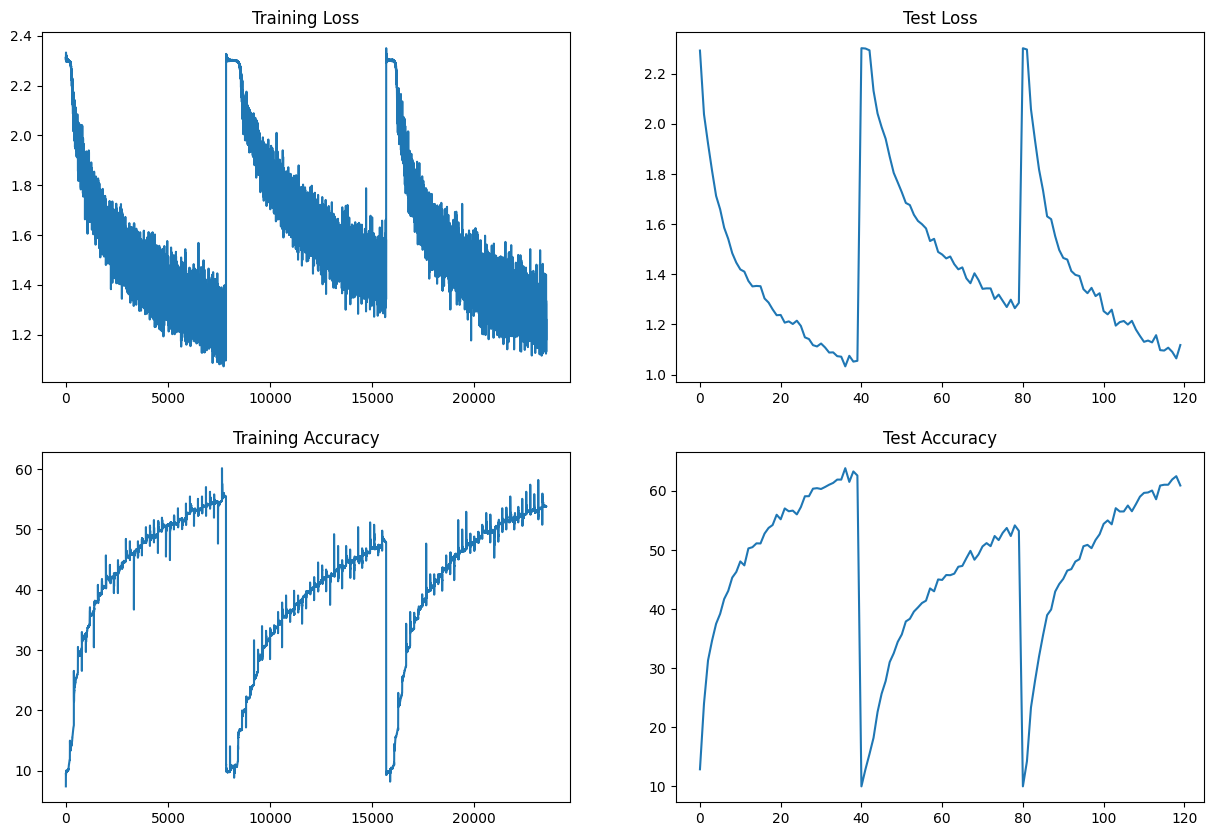

In [86]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

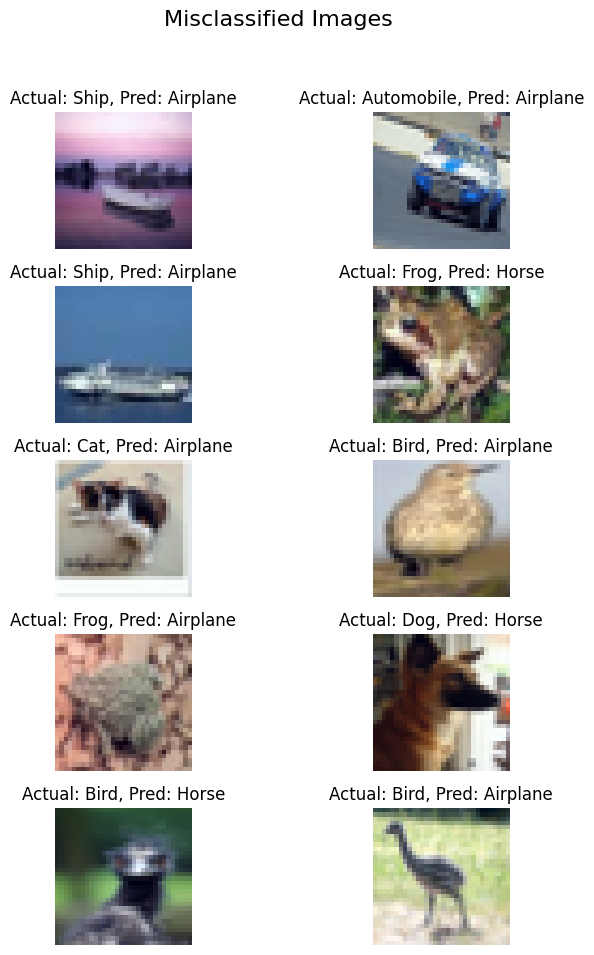

In [81]:
show_misclasses(failed_samples,"Misclassified Images ")

# Analysis 1: Batch Normalisation Network


Achieving **70%** accuracy on **CIFAR-10** with the compact **NetA** model, using **Batch Normalization** and fewer than 50k parameters, illustrates the power of efficient neural network design. This approach, which foregoes data augmentation, emphasizes the importance of Batch Normalization in boosting model performance and generalization. This achievement underscores the potential for creating high-accuracy, low-parameter models for image classification, highlighting the effectiveness of strategic architecture and training optimisation

---
---
---